In [2]:
import numpy as np
import matplotlib.pyplot as plt
from quantum_code import *
from classical_code import *
import stim
from tqdm import tqdm
from ldpc import BpDecoder, BpOsdDecoder
from ldpc.bplsd_decoder import BpLsdDecoder
# %load_ext snakeviz

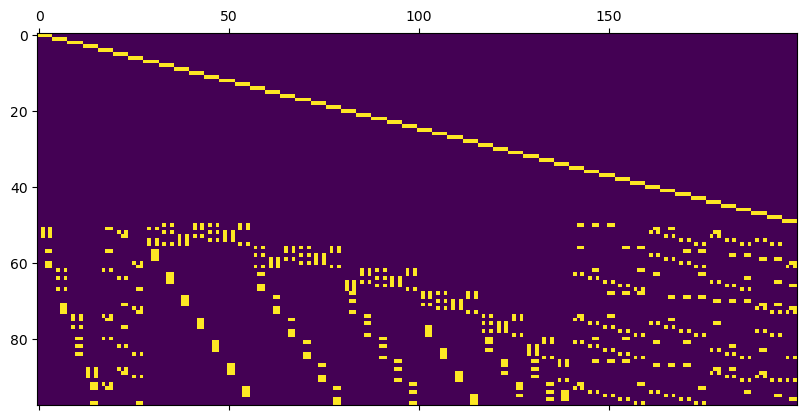

In [3]:
hgp_qcode = read_qcode("../codes/qcodes/HGP_100_4/HGP_100_4.qcode")
qcode = hgp_qcode
qcode = read_qcode("../codes/qcodes/HGP_100_4/HGP_C422_200_4.qcode")
# qcode = read_qcode("../codes/qcodes/HGP_C422_400_8.qcode")


# hgp_qcode = read_qcode("../codes/qcodes/HGP_400_16/HGP_400_16.qcode")
# qcode = hgp_qcode
# qcode = read_qcode("../codes/qcodes/HGP_400_16/HGP_C422_800_16.qcode")


# hgp_qcode = read_qcode("../codes/qcodes/HGP_900_36/HGP_900_36.qcode")
# qcode = hgp_qcode
# qcode = read_qcode("../codes/qcodes/HGP_900_36/HGP_C422_1800_36.qcode")

# hgp_qcode = read_qcode("../codes/qcodes/HGP_1600_64/HGP_1600_64.qcode")
# qcode = hgp_qcode


# concatenate_iceberg(qcode, 6, "../codes/qcodes/")
# concatenate_iceberg2(qcode, 4, "../codes/qcodes/")
# concatenate_steane(qcode, "../codes/qcodes/")


hgp_Hx, hgp_Hz, hgp_Lx, hgp_Lz, _ = hgp_qcode.to_numpy()
Hx, Hz, Lx, Lz, mapping = qcode.to_numpy()


qubit_error_rate = 0.001
meas_error_rate = 0.001

stab_type = False
concat = True if meas_error_rate else False
soft = True

H = Hx if stab_type else Hz
hgp_H = hgp_Hx if stab_type else hgp_Hz

qec_aug_dec_Hx = np.hstack([hgp_Hx, np.eye(hgp_Hx.shape[0], dtype=int)])
qec_aug_dec_Hz = np.hstack([hgp_Hz, np.eye(hgp_Hz.shape[0], dtype=int)])
qec_aug_channel_probs = [0.01]*hgp_H.shape[1] + [0.01]*(hgp_H.shape[0])

qec_dec_Hx = hgp_Hx
qec_dec_Hz = hgp_Hz
qec_channel_probs = [0.01]*hgp_H.shape[1]

plt.matshow(H)
# print(np.count_nonzero(Hx, axis=1))

In [4]:
def iceberglogicals(n):
    icebergX = np.zeros(shape=(n-2,2), dtype=int)
    icebergZ = np.zeros(shape=(n-2,2), dtype=int)

    for i in range(n-2):
        icebergX[i] = np.array([0,i+1])
        icebergZ[i] = np.array([i+1,n-1])

    return icebergX, icebergZ
icebergX, icebergZ = iceberglogicals(4)

In [5]:
qec_aug_decZ = BpDecoder(
    qec_aug_dec_Hz,
    channel_probs=qec_aug_channel_probs,
    bp_method="ps",
    max_iter=30,
    schedule="serial",
    # lsd_method="lsd0"
    # osd_order=4 #the osd search depth
)

qec_decZ = BpLsdDecoder(
    qec_dec_Hz,
    channel_probs=qec_channel_probs,
    bp_method="ps",
    max_iter=30,
    schedule="serial",
    lsd_method="lsd_cs",
    lsd_order=4 #the osd search depth
)

qec_aug_decX = BpDecoder(
    qec_aug_dec_Hx,
    channel_probs=qec_aug_channel_probs,
    bp_method="ps",
    max_iter=30,
    schedule="serial",
    # lsd_method="lsd0"
    # osd_order=4 #the osd search depth
)

qec_decX = BpLsdDecoder(
    qec_dec_Hx,
    channel_probs=qec_channel_probs,
    bp_method="ps",
    max_iter=30,
    schedule="serial",
    lsd_method="lsd_cs",
    lsd_order=4 #the osd search depth
)



def decode(curr_synd, augment, stab_type):
    H = Hx if stab_type else Hz
    guessed_error = np.zeros(H.shape[1], dtype=int)
    qec_aug_dec = qec_aug_decX if stab_type else qec_aug_decZ
    qec_dec = qec_decX if stab_type else qec_decZ

    if not concat:
        # QEC only
        if augment:
            guessed_error ^= qec_aug_dec.decode(curr_synd[qedm:])[:hgp_H.shape[1]]
        else:
            guessed_error ^= qec_dec.decode(curr_synd[qedm:])
    elif concat:
        # QED + QEC
        curr_qed_synd = curr_synd[:qedm]
        curr_hgp_synd = curr_synd[qedm:]

        block_correction = np.array([0,0,0,1], dtype=int) if stab_type else np.array([1,0,0,0], dtype=int)
        corrections = np.concatenate([block_correction if x == 1 else np.zeros(4, dtype=int) for x in curr_qed_synd])
        guessed_error ^= corrections

        # pot_corrections = np.eye(4, dtype=int)
        # corrections = np.concatenate([pot_corrections[np.random.randint(0,4)] if x == 1 else np.zeros(4, dtype=int) for x in curr_qed_synd])
        # guessed_error ^= corrections
        # curr_hgp_synd ^= ((H @ corrections) % 2)[qedm:]

        #######################
        if soft:
            new_channel_probs = 0.01 * np.ones(hgp_H.shape[1])
            new_channel_probs[mapping[curr_qed_synd == 1].flatten()] = 0.25
            if augment:
                new_channel_probs = np.concatenate([new_channel_probs, [0.01]*hgp_H.shape[0]])
                qec_aug_dec.update_channel_probs(new_channel_probs)
            else:
                qec_dec.update_channel_probs(new_channel_probs)
        ########################

        if augment:
            logical_correction = qec_aug_dec.decode(curr_hgp_synd)[:hgp_H.shape[1]]
        else:
            logical_correction = qec_dec.decode(curr_hgp_synd)[:hgp_H.shape[1]]

        physical_correction = np.zeros(Hx.shape[1], dtype=int)

        for c in np.where(logical_correction)[0]:
                iceberg_block = np.where(mapping == c)[0][0]
                iceberg_log = np.where(mapping == c)[1][0]
                if stab_type:
                        physical_correction[icebergZ[iceberg_log]+(4*iceberg_block)] ^= 1
                else:
                        physical_correction[icebergX[iceberg_log]+(4*iceberg_block)] ^= 1

        guessed_error ^= physical_correction
    return guessed_error


overlapping_x_generators = np.empty(qcode.qedxm, dtype=object)
for i in range(qcode.qedxm):
    tmp = np.array([], dtype=int)
    for j in range(qcode.qedxm,qcode.xm):
        if np.any(Hx[i] & Hx[j]): tmp = np.append(tmp, j)
    overlapping_x_generators[i] = tmp

overlapping_z_generators = np.empty(qcode.qedxm, dtype=object)
for i in range(qcode.qedzm):
    tmp = np.array([], dtype=int)
    for j in range(qcode.qedzm,qcode.zm):
        if np.any(Hz[i] & Hz[j]): tmp = np.append(tmp, j)
    overlapping_z_generators[i] = tmp

def get_overlapping(measurements, gen_type=False, not_overlapping=False):
    overlapping_generators = overlapping_x_generators if gen_type else overlapping_z_generators
    gens_to_measure = set()
    for g in np.where(measurements)[0]:
        gens_to_measure |= set(overlapping_generators[g])

    if not_overlapping:
        return np.array(list(set(np.arange(qcode.qedxm,qcode.xm)) ^ gens_to_measure))
    else:
        return np.array(list(gens_to_measure))


cn = qcode.n
cm = qcode.xm
qedm = qcode.qedxm
data_qbts = np.arange(cn)
# x_checks = np.arange(cn,cn+cmx)
# z_checks = np.arange(cn+cmx,cn+cmx+cmz)
cats = np.arange(cn, cn+max(np.count_nonzero(H, axis=1)))

def prepare_cat_state(size):
    c = stim.Circuit()
    # c.append("R", cats)
    c.append("H", cats[0])
    for i in range(size-1):
        c.append("CX", [cats[i], cats[i+1]])
    return c

precomputed_x_checks_circuits = np.empty(cm, dtype=object)
for x in np.arange(qcode.xm):
    c = stim.Circuit()
    gen_qbts = data_qbts[np.where(Hx[x])[0]]
    c += prepare_cat_state(len(gen_qbts))
    cat_qbts = [cats[i] for i in range(len(gen_qbts))]

    for i, qbt in enumerate(gen_qbts):
        path_qbts = [cat_qbts[i], qbt]
        c.append("CX", path_qbts)
        c.append("DEPOLARIZE2", path_qbts, qubit_error_rate)

    c.append("H", cat_qbts)
    c.append("DEPOLARIZE1", cat_qbts, qubit_error_rate)

    c.append("X_ERROR", cat_qbts, meas_error_rate)
    c.append("MR", cat_qbts)

    precomputed_x_checks_circuits[x] = c

def prepare_x_checks(checks):
    c = stim.Circuit()
    if len(checks) == 0: return c
    for x in checks:
        c += precomputed_x_checks_circuits[x]
    return c

precomputed_z_checks_circuits = np.empty(cm, dtype=object)
for z in np.arange(qcode.zm):
    c = stim.Circuit()
    gen_qbts = data_qbts[np.where(Hz[z])[0]]
    c += prepare_cat_state(len(gen_qbts))
    cat_qbts = [cats[i] for i in range(len(gen_qbts))]

    for i, qbt in enumerate(gen_qbts):
        path_qbts = [qbt, cat_qbts[i]][::-1]
        c.append("CZ", path_qbts)
        c.append("DEPOLARIZE2", path_qbts, qubit_error_rate)

    c.append("H", cat_qbts)
    c.append("DEPOLARIZE1", cat_qbts, qubit_error_rate)

    c.append("X_ERROR", cat_qbts, meas_error_rate)
    c.append("MR", cat_qbts)

    precomputed_z_checks_circuits[z] = c

def prepare_z_checks(checks):
    c = stim.Circuit()
    if len(checks) == 0: return c
    for z in checks:
        c += precomputed_z_checks_circuits[z]
    return c

def build_syndrome(meas, curr_checks):
    counter = 0
    synd = np.zeros(cm, dtype=int)
    for check in curr_checks:
        if qedm:
            weight = 4 if check < qedm else 14
        else:
            weight = 7
        synd[check] = sum(meas[counter:counter+weight]) % 2
        counter += weight
    return synd

class Simulation:
    def __init__(self, num_rounds, stab_type, concat=True, adaptive=True):
        self.num_rounds = num_rounds
        self.stab_type = stab_type
        self.curr_round = 1
        self.concat = concat
        self.adaptive = adaptive

        self.z_check_history = np.ones(cm, dtype=int)
        self.x_check_history = np.ones(cm, dtype=int)
        self.z_syndrome_history = np.zeros(shape=(num_rounds+2, cm), dtype=int)
        self.x_syndrome_history = np.zeros(shape=(num_rounds+2, cm), dtype=int)
        self.z_observables = np.zeros(qcode.k, dtype=int)
        self.x_observables = np.zeros(qcode.k, dtype=int)

        self.c = stim.Circuit()
        self.s = stim.TableauSimulator()

        if self.stab_type:
            self.c.append("H", [qbt for qbt in data_qbts])
            self.c += prepare_z_checks(np.arange(cm)).without_noise()
        else:
            self.c += prepare_x_checks(np.arange(cm)).without_noise()

        self.s.do_circuit(self.c)
        init_synd = build_syndrome(self.s.current_measurement_record(), np.arange(cm))
        if self.stab_type:
            self.z_syndrome_history[0] = init_synd
        else:
            self.x_syndrome_history[0] = init_synd


    def QED(self):
        c = stim.Circuit()
        if self.stab_type:
            c += prepare_x_checks(np.arange(qedm))
            c += prepare_z_checks(np.arange(qedm))
        else:
            c += prepare_z_checks(np.arange(qedm))
            c += prepare_x_checks(np.arange(qedm))

        return c

    def QEC(self):
        c = stim.Circuit()
        if self.stab_type:
            c += prepare_x_checks(self.curr_x_checks)
            c += prepare_z_checks(self.curr_z_checks)
        else:
            c += prepare_z_checks(self.curr_z_checks)
            c += prepare_x_checks(self.curr_x_checks)
        return c

    def final_synd_and_observables(self):
        c = stim.Circuit()

        if self.stab_type: c.append("H", [qbt for qbt in data_qbts])
        c.append("M", data_qbts)

        self.s.do_circuit(c)
        self.c += c

        meas = self.s.current_measurement_record()[-cn:]
        H = Hx if self.stab_type else Hz
        for i in range(H.shape[0]):
            incl_qbts = np.where(H[i])[0]
            incl_qbts = np.array([j-cn for j in incl_qbts])

            if self.stab_type:
                self.x_syndrome_history[-1][i] = np.sum(np.take(meas, incl_qbts)) % 2
            else:
                self.z_syndrome_history[-1][i] = np.sum(np.take(meas, incl_qbts)) % 2

        for i, logical in enumerate(Lx if self.stab_type else Lz):
            incl_qbts = np.where(logical)[0]
            incl_qbts = [j-cn for j in incl_qbts]

            if self.stab_type:
                self.x_observables[i] = (np.sum(np.take(meas, incl_qbts)) % 2)
            else:
                self.z_observables[i] = (np.sum(np.take(meas, incl_qbts)) % 2)

        if self.stab_type:
            final_correction = decode(self.x_syndrome_history[-1], 0, True)
            self.x_observables ^= (Lx @ final_correction) % 2
        else:
            final_correction = decode(self.z_syndrome_history[-1], 0, False)
            self.z_observables ^= (Lz @ final_correction) % 2


    def simulate(self):
        self.s.x(1)
        for _ in range(1, self.num_rounds+1):
            self.s.depolarize1(*data_qbts, p=qubit_error_rate)

            self.curr_z_checks = np.zeros(cm)
            self.curr_x_checks = np.zeros(cm)
            if (not self.adaptive):
                self.curr_z_checks = np.arange(cm)
                self.curr_x_checks = np.arange(cm)
            else:
                QED_circuit = self.QED()
                self.s.do_circuit(QED_circuit)
                self.c += QED_circuit

                # determining which of the QEC stabilizers to measure
                meas = self.s.current_measurement_record()
                if self.stab_type:
                    self.x_syndrome_history[self.curr_round][:qedm] = meas[-(8*qedm):-(4*qedm)]
                    self.z_syndrome_history[self.curr_round][:qedm] = meas[-(4*qedm):]

                    z_qed_synd_diff = self.z_syndrome_history[self.curr_round][:qedm] ^ self.z_syndrome_history[0][:qedm]
                    x_qed_synd_diff = self.x_syndrome_history[self.curr_round][:qedm]
                    self.curr_z_checks = sorted(get_overlapping(z_qed_synd_diff, False))
                    self.curr_x_checks = sorted(get_overlapping(x_qed_synd_diff, True))
                else:
                    self.x_syndrome_history[self.curr_round] = self.x_syndrome_history[0]
                    self.z_syndrome_history[self.curr_round][:qedm] = build_syndrome(meas[-(8*qedm):-(4*qedm)], np.arange(qedm))[:qedm]
                    self.x_syndrome_history[self.curr_round][:qedm] = build_syndrome(meas[-(4*qedm):], np.arange(qedm))[:qedm]

                    x_qed_synd_diff = self.x_syndrome_history[self.curr_round][:qedm] ^ self.x_syndrome_history[0][:qedm]
                    z_qed_synd_diff = self.z_syndrome_history[self.curr_round][:qedm]
                    self.curr_x_checks = sorted(get_overlapping(x_qed_synd_diff, True))
                    self.curr_z_checks = sorted(get_overlapping(z_qed_synd_diff, False))

                # if (_ > 1) and ((_ - 1) % 10 == 0):
                #     self.curr_z_checks = np.arange(qedm, cmz)
                #     self.curr_x_checks = np.arange(qedm, cmx)

            confirmation_z = np.concatenate([np.ones(qedm, dtype=int), np.zeros(cm-qedm, dtype=int)])
            confirmation_z[self.curr_z_checks] = 1
            confirmation_x = np.concatenate([np.ones(qedm, dtype=int), np.zeros(cm-qedm, dtype=int)])
            confirmation_x[self.curr_x_checks] = 1
            self.z_check_history = np.vstack([self.z_check_history, confirmation_z])
            self.x_check_history = np.vstack([self.x_check_history, confirmation_x])

            QEC_circuit = self.QEC()
            self.s.do_circuit(QEC_circuit)
            self.c += QEC_circuit

            meas = self.s.current_measurement_record()
            w = 14 if qedm else 7
            lookback = lambda x: -w*len(x) if len(x) else None
            if self.stab_type:
                if len(self.curr_x_checks):
                    self.x_syndrome_history[self.curr_round][self.curr_x_checks] = build_syndrome(meas[lookback(np.concatenate([self.curr_x_checks, self.curr_z_checks])):
                                                                        lookback(self.curr_z_checks)], self.curr_z_checks)
                if len(self.curr_z_checks):
                    self.z_syndrome_history[self.curr_round][self.curr_z_checks] = build_syndrome(meas[lookback(self.curr_z_checks):], self.curr_z_checks)
            else:
                if len(self.curr_z_checks):
                    self.z_syndrome_history[self.curr_round][self.curr_z_checks] = build_syndrome(meas[lookback(np.concatenate([self.curr_z_checks, self.curr_x_checks])):
                                                                        lookback(self.curr_x_checks)], self.curr_z_checks)[self.curr_z_checks]
                if len(self.curr_x_checks):
                    self.x_syndrome_history[self.curr_round][self.curr_x_checks] = build_syndrome(meas[lookback(self.curr_x_checks):], self.curr_x_checks)[self.curr_x_checks]

            if self.stab_type:
                guessed_z_error = decode(self.x_syndrome_history[self.curr_round], 1, True)
                self.s.z(*np.where(guessed_z_error)[0])
                guessed_x_error = decode(self.z_syndrome_history[self.curr_round] ^ self.z_syndrome_history[0], 1, False)
                self.s.x(*np.where(guessed_x_error)[0])
            else:
                guessed_x_error = decode(self.z_syndrome_history[self.curr_round], 1, False)
                self.s.x(*np.where(guessed_x_error)[0])
                guessed_z_error = decode(self.x_syndrome_history[self.curr_round] ^ self.x_syndrome_history[0], 1, True)
                self.s.z(*np.where(guessed_z_error)[0])

            self.curr_round += 1

        self.final_synd_and_observables()

In [6]:
# %%snakeviz

concat = True if qedm else False
adaptive = True if qedm else False
# adaptive = False

num_iters = 100
num_rounds = 10
successes = 0
num_gens = []
for i in tqdm(range(num_iters)):
    s = Simulation(num_rounds, stab_type, concat=concat, adaptive=adaptive)
    s.simulate()
    c = s.c

    if np.any(s.z_observables):
        pass
    else:
        successes += 1
print(successes)

100%|██████████| 100/100 [00:05<00:00, 18.19it/s]

96


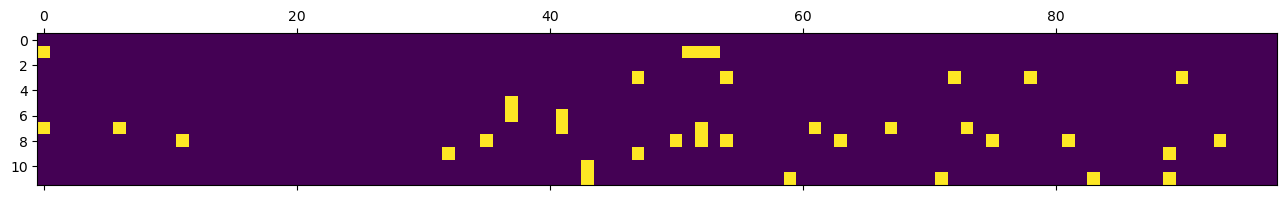

In [415]:
plt.matshow(s.z_syndrome_history)

In [353]:
e = np.zeros(H.shape[1], dtype=int)
e[1] = 1
(Hz @ e) % 2

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

stim.Circuit('''
    H 100
    CX 100 101 101 102 102 103 103 104 104 105 105 106 100 16 101 32 102 40 103 56 104 65 105 66 106 67
    H 100 101 102 103 104 105 106
    MR 100 101 102 103 104 105 106
    H 100
    CX 100 101 101 102 102 103 103 104 104 105 105 106 100 17 101 33 102 41 103 57 104 65 105 68 106 69
    H 100 101 102 103 104 105 106
    MR 100 101 102 103 104 105 106
    H 100
    CX 100 101 101 102 102 103 103 104 104 105 105 106 100 18 101 34 102 42 103 58 104 64 105 66 106 69
    H 100 101 102 103 104 105 106
    MR 100 101 102 103 104 105 106
    H 100
    CX 100 101 101 102 102 103 103 104 104 105 105 106 100 19 101 35 102 43 103 59 104 67 105 68 106 69
    H 100 101 102 103 104 105 106
    MR 100 101 102 103 104 105 106
    H 100
    CX 100 101 101 102 102 103 103 104 104 105 105 106 100 20 101 36 102 44 103 60 104 64 105 65 106 67
    H 100 101 102 103 104 105 106
    MR 100 101 102 103 104 105 106
    H 100
    CX 100 101 101 102 102 103 103 104 104 105 105 106 100

In [421]:
s = stim.TableauSimulator()
c = stim.Circuit()

c.append("X", 0)
c += precomputed_z_checks_circuits[0]
c += precomputed_z_checks_circuits[1]

s.do(c)

s.current_measurement_record()

[False, True, False, False, True, False, True, False]

In [422]:
c

stim.Circuit('''
    X 0
    H 200
    CX 200 201 201 202 202 203
    CZ 200 0
    DEPOLARIZE2(0.001) 200 0
    CZ 201 1
    DEPOLARIZE2(0.001) 201 1
    CZ 202 2
    DEPOLARIZE2(0.001) 202 2
    CZ 203 3
    DEPOLARIZE2(0.001) 203 3
    H 200 201 202 203
    DEPOLARIZE1(0.001) 200 201 202 203
    X_ERROR(0.001) 200 201 202 203
    MR 200 201 202 203
    H 200
    CX 200 201 201 202 202 203
    CZ 200 4
    DEPOLARIZE2(0.001) 200 4
    CZ 201 5
    DEPOLARIZE2(0.001) 201 5
    CZ 202 6
    DEPOLARIZE2(0.001) 202 6
    CZ 203 7
    DEPOLARIZE2(0.001) 203 7
    H 200 201 202 203
    DEPOLARIZE1(0.001) 200 201 202 203
    X_ERROR(0.001) 200 201 202 203
    MR 200 201 202 203
''')